## Ames Model selection

In [106]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [107]:
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [116]:
from sklearn import linear_model

X_train = pd.read_csv('x_train_dummies.csv')
y_train = pd.read_csv('y_train_dummies.csv')
X_test = pd.read_csv('x_test_dummies.csv')
y_test = pd.read_csv('y_test_dummies.csv')

scaler = StandardScaler()

# Fix the scale model using the train set
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [117]:
model  = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
model.set_params(normalize=True)
trainscore = []
testscore = []

model.fit(X_train, y_train)  

coefs  = model.coef_.T
A = list(zip(X_train.columns.to_list(), coefs))

trainscore.append(model.score(X_train, y_train))
testscore.append(model.score(X_test, y_test))

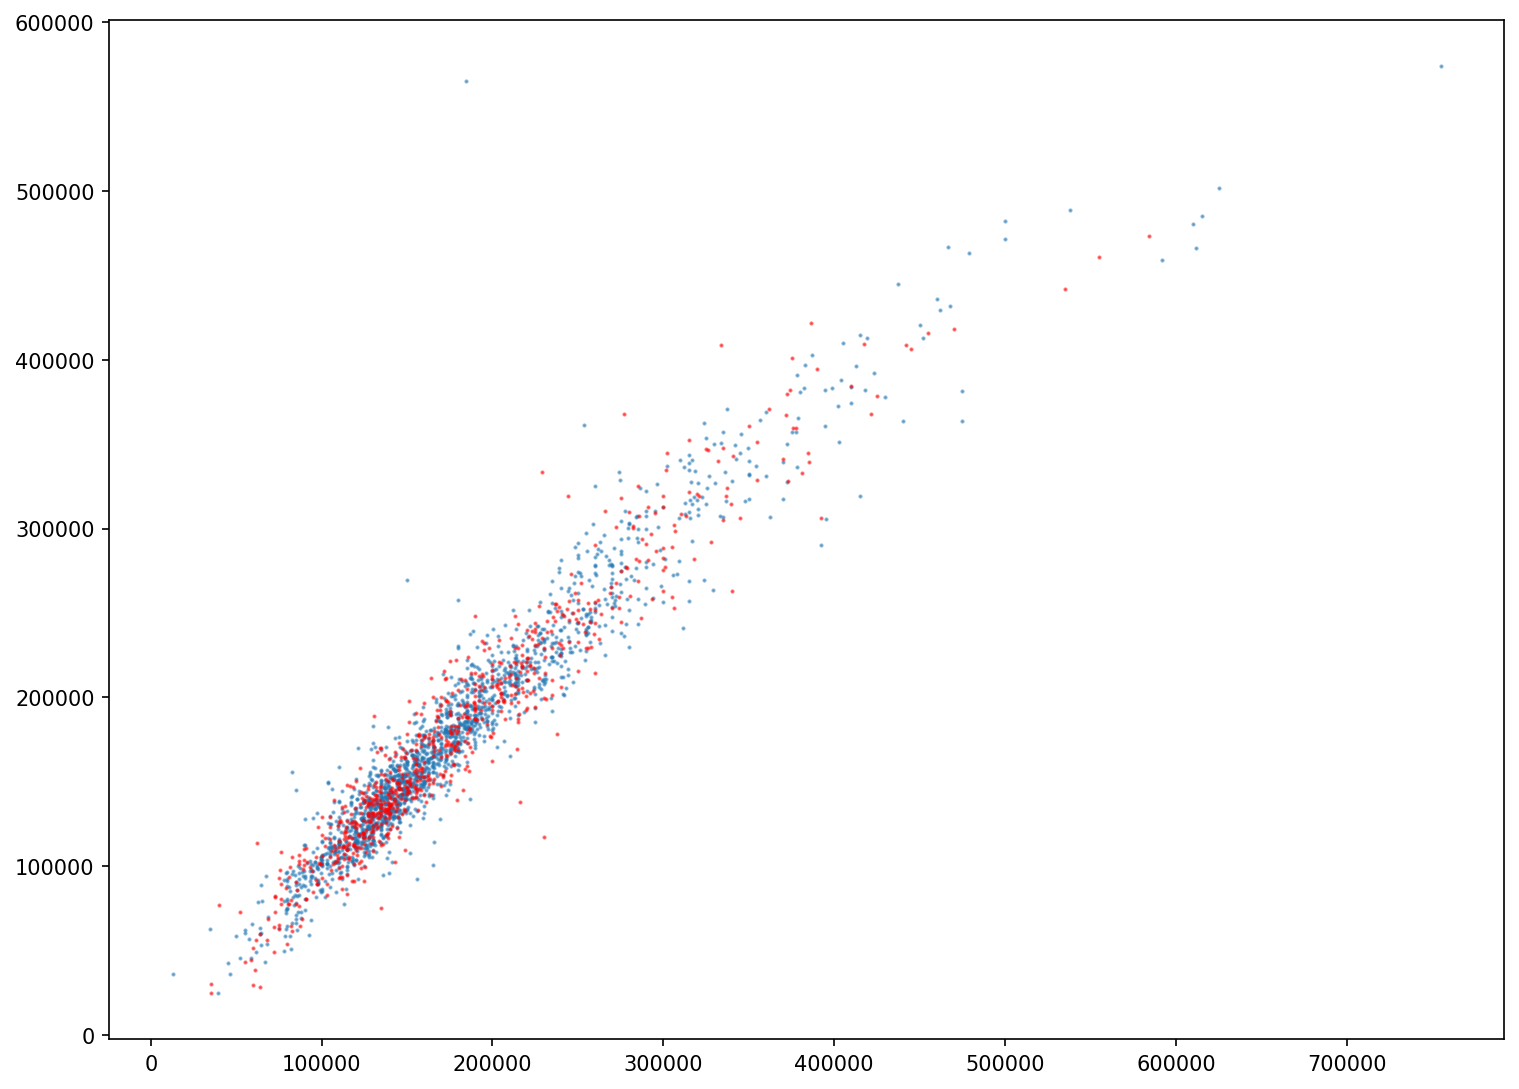

In [115]:
plt.figure(figsize=(12, 9), dpi=150)
plt.scatter(y_train,model.predict(X_train), alpha = 0.5, s = 1)
plt.scatter(y_test,model.predict(X_test), alpha = 0.5, s = 1, color = 'red')


# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXx

In [22]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def get_confusion_matrix(bi_clf, X, y, thres=0.5):
    """Only good for a binary classifier
    """
    return confusion_matrix(
        y,
        bi_clf.predict_proba(X)[:,1] > thres
    )

get_confusion_matrix(logistic, X_test, y_test)

array([[1243,   45],
       [ 169,   43]], dtype=int64)

Below, try to change the cuf-off probability to trade off between true positive and true negative:

In [23]:
get_confusion_matrix(logistic, X_test, y_test, 0.45) # Try 0.4, 0.3, 0.2, ...

array([[1229,   59],
       [ 158,   54]], dtype=int64)

How good this trading off is can be measured by the **area under the receiver opearting characteristic curve**, or **roc_auc**.

In [24]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, logistic.predict_proba(X_test)[:,1]))
get_confusion_matrix(logistic, X_test, y_test, 0.15) # <<< 0.15 is chosen for a reason to be explained.

0.7925626977616314


array([[992, 296],
       [ 61, 151]], dtype=int64)

Below we train a logistic regression with `class_weight='balanced'` to end up with a slightly higher roc_auc. That indicates a better trading off between true positive and true negative. Indeed, with 150 true positive cases this new model has higher true negative than the last model.

In [25]:
b_logistic = LogisticRegression(C=1e8, solver='liblinear', class_weight='balanced')
b_logistic.fit(X_train, y_train)
print(roc_auc_score(y_test, b_logistic.predict_proba(X_test)[:,1]))
get_confusion_matrix(b_logistic, X_test, y_test, 0.5) 

0.7948406187741709


array([[993, 295],
       [ 63, 149]], dtype=int64)

Here we see that the `roc_auc` is a more "useful" metric to evaluate our classification model than the accuracy.

## Model Selection/Grid Search

From the logistic regression we trained, we used a large `C` without a justification. In fact, that might not be the best case. Now that we agree to evaluate our model with `roc_auc` , it's intuitive to select our model as below:

In [26]:
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(X_train, y_train)
    print("C =", C)
    print("Test Score", logistic.score(X_test, y_test), "\n")

C = 0.0001
Test Score 0.8593333333333333 

C = 0.01
Test Score 0.8606666666666667 

C = 1
Test Score 0.8546666666666667 

C = 100
Test Score 0.8593333333333333 

C = 10000
Test Score 0.858 

C = 1000000
Test Score 0.858 

C = 100000000
Test Score 0.8573333333333333 



So this is why people often call the model selection process **grid search**: searching from the parameter grid for the one that produces the highest score. When searching for more than one paramter, the candidates form a grid.

The problem with the approach above is that the dataset is not used efficiently. Some observations are never used for training and some are never used for testing. **Cross validation** can help.

In [27]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3)
for training_idx, validation_idx in kfold.split(X_train, y_train):
    print(training_idx, " consists of {} indexes.".format(len(training_idx)))
    print(validation_idx, " consists of {} indexes.".format(len(validation_idx)))
    print("\n")

[1167 1168 1169 ... 3497 3498 3499]  consists of 2333 indexes.
[   0    1    2 ... 1164 1165 1166]  consists of 1167 indexes.


[   0    1    2 ... 3497 3498 3499]  consists of 2333 indexes.
[1167 1168 1169 ... 2331 2332 2333]  consists of 1167 indexes.


[   0    1    2 ... 2331 2332 2333]  consists of 2334 indexes.
[2334 2335 2336 ... 3497 3498 3499]  consists of 1166 indexes.




So to evaluate a model:

In [28]:
lm = LogisticRegression(C=1, solver='liblinear')

scores = []
for training_idx, validation_idx in kfold.split(X_train, y_train):
    X_ = X_train.iloc[training_idx,:]
    y_ = y_train.iloc[training_idx]
    lm.fit(X_, y_)
    scores.append(
        lm.score(X_train.iloc[validation_idx], y_train.iloc[validation_idx]))
    
print(
    "The 'cross-validation score' for the logistic regression with C={} is {}".format(
        lm.get_params()["C"], np.mean(scores)))

The 'cross-validation score' for the logistic regression with C=1 is 0.8662861823845477


`cross_val_score` helps to avoid a for loop.

In [29]:
from sklearn.model_selection import cross_val_score

lm = LogisticRegression(C=1, solver='liblinear')
scores = cross_val_score(lm, X_train, y_train, cv=kfold)
print(scores)
print(
    "The 'cross-validation score' for the logistic regression with C={} is {}".format(
        lm.get_params()["C"], np.mean(scores)))

[0.86718081 0.86375321 0.86792453]
The 'cross-validation score' for the logistic regression with C=1 is 0.8662861823845477


In some cases, you might want to shuffle the indexes:

In [30]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
for training_idx, validation_idx in kfold.split(X_train, y_train):
    print(training_idx, " consists of {} indexes.".format(len(training_idx)))
    print(validation_idx, " consists of {} indexes.".format(len(validation_idx)))
    print("\n")

[   0    3    5 ... 3496 3497 3498]  consists of 2333 indexes.
[   1    2    4 ... 3491 3495 3499]  consists of 1167 indexes.


[   0    1    2 ... 3497 3498 3499]  consists of 2333 indexes.
[   5    6    8 ... 3485 3486 3494]  consists of 1167 indexes.


[   1    2    4 ... 3494 3495 3499]  consists of 2334 indexes.
[   0    3    7 ... 3496 3497 3498]  consists of 1166 indexes.




### Varying Distribution of The Dependent Variable

With shuffling or not, one issue with random sampling is that the distributions of the dependent variable vary:

In [31]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
for training_idx, validation_idx in kfold.split(X_train, y_train):
    print("The churn rate of the training set of this fold is {}.".format(y_train.iloc[training_idx].mean()))
    print("The churn rate of the validation set of this fold is {}.".format(y_train.iloc[validation_idx].mean()))
    print("\n")

The churn rate of the training set of this fold is 0.1491641663094728.
The churn rate of the validation set of this fold is 0.12596401028277635.


The churn rate of the training set of this fold is 0.12944706386626662.
The churn rate of the validation set of this fold is 0.16538131962296487.


The churn rate of the training set of this fold is 0.1456726649528706.
The churn rate of the validation set of this fold is 0.13293310463121785.




`StratifiedKFold` comes in handy:

In [32]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for training_idx, validation_idx in skfold.split(X_train, y_train):
    print("The churn rate of the training set of this fold is {}.".format(y_train.iloc[training_idx].mean()))
    print("The churn rate of the validation set of this fold is {}.".format(y_train.iloc[validation_idx].mean()))
    print("\n")

The churn rate of the training set of this fold is 0.14144877839691383.
The churn rate of the validation set of this fold is 0.14138817480719795.


The churn rate of the training set of this fold is 0.14144877839691383.
The churn rate of the validation set of this fold is 0.14138817480719795.


The churn rate of the training set of this fold is 0.14138817480719795.
The churn rate of the validation set of this fold is 0.14150943396226415.




### Grid Search with A `sklearn` Function:

We started with the following "grid search":

```python
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(X_train, y_train)
    print("C =", C)
    print("Test Score", logistic.score(X_test, y_test), "\n")
```

, then we showed how we switch to a grid search with cross-validation:

In [33]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

result = {}
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    result[C] = cross_val_score(logistic, X_train, y_train, cv=skfold).mean()
    
result

{0.0001: 0.8600005487282977,
 0.01: 0.8602852015327157,
 1: 0.8674287130900605,
 100: 0.8694264270487775,
 10000: 0.8702838150138921,
 1000000: 0.8702833250779122,
 100000000: 0.8697123046931458}

In [34]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

result = {}
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, penalty = 'l1', solver='liblinear')
    result[C] = cross_val_score(logistic, X_train, y_train, cv=skfold).mean()
    
result

{0.0001: 0.8585714054744468,
 0.01: 0.860571324145074,
 1: 0.8682834064072847,
 100: 0.8705694476902703,
 10000: 0.8699979373695239,
 1000000: 0.8699976924015339,
 100000000: 0.8702835700459021}

To spare another for loop, one can use `GridSearchCV`:

In [35]:
from sklearn.model_selection import GridSearchCV

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
logistic = LogisticRegression(solver='liblinear')
params = {
    "C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

gs = GridSearchCV(logistic, params, cv=skfold)
gs.fit(X_train, y_train)
gs.cv_results_['mean_test_score']

array([0.86000055, 0.8602852 , 0.86742871, 0.86942643, 0.87028382,
       0.87028333, 0.8697123 ])

So with this, we obtain our best `C`. You might have noticed that with `GridSearch`, `X_test` and `y_test` are not used yet. Both training and validation were done within the training data. The reason for that is that we need to keep a dataset that is not used to decide any part of our model. 

Inspect the for loop that we began with:

```python
for C in [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]:
    logistic = LogisticRegression(C=C, solver='liblinear')
    logistic.fit(X_train, y_train)
    print("C =", C)
    print("Test Score", logistic.score(X_test, y_test), "\n")
```

If we ended up with the `C` that gives us the highest test score, then `X_test` and `y_test` are involved with the decisino of `C` so they can't be used to evaluate our final model. But that's not a problem if we used `GridSearch`.

In [34]:
gs.score(X_test, y_test) # The final model is the one with the best C from the grid search 
                         # and fitted on the whole training dataset.

0.8586666666666667

### `pipeline`

Now that we understand a (at least to the extent that most practitioners would call) complete and general model selection process, let's inspect the grid search process above for our specific case. Is that a good grid search process for a logistic regression with penalty? Have we properly taken care of the imbalanced data?

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logistic = LogisticRegression(max_iter=500, solver='liblinear', class_weight="balanced")
pipe = Pipeline([ 
    ("standardize", StandardScaler()), ('logit', logistic)])

params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000]
}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)

start= time.time()
gs.fit(X_train, y_train)
print(time.time() - start)

print("The best parameters are: ", gs.best_params_)
print("The score roc_auc score of the final model: ", gs.score(X_test, y_test))
print("An alternative way to obtain roc_auc: ", roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
get_confusion_matrix(gs, X_test, y_test)

10.09070611000061
The best parameters are:  {'logit__C': 0.01}
The score roc_auc score of the final model:  0.799645493964608
An alternative way to obtain roc_auc:  0.799645493964608


array([[962, 326],
       [ 56, 156]])

**Syntax Notes**: Every step in a pipeline can be cross validated.

In [36]:
new_params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000, 1000000, 100000000],
    "standardize__with_mean": [True, False],
    "standardize__with_std": [True, False]
}

gs = GridSearchCV(pipe, new_params, scoring="roc_auc", cv=skfold)
start= time.time()
gs.fit(X_train, y_train)
print(time.time() - start)

print("The best parameters are: ", gs.best_params_)
print("The score roc_auc score of the final model: ", gs.score(X_test, y_test))
get_confusion_matrix(gs, X_test, y_test)

25.06839895248413
The best parameters are:  {'logit__C': 1, 'standardize__with_mean': True, 'standardize__with_std': False}
The score roc_auc score of the final model:  0.8004731630141801


array([[993, 295],
       [ 59, 153]])

## Scoring, Reality, and Randomness

Recall that we use `roc_auc` to optimize the trade off between the sensivity and specificity. Ideally, when comparing two models, the one with a higher `roc_auc` can reach the same sentivity as the other model with higher specificity, the same specificity with a higher sensitivity. See the demo below:

In [37]:
# set seed  = 0
seed = 0

X_train, X_test, y_train, y_test = train_test_split(
    churn_features, churn_label, test_size=0.3, stratify=churn_label, random_state=seed)


skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)
gs.fit(X_train, y_train)

print("The best parameters are: ", gs.best_params_)
print("The score roc_auc score of the final model: ", gs.score(X_test, y_test))
get_confusion_matrix(gs, X_test, y_test)

The best parameters are:  {'logit__C': 0.01}
The score roc_auc score of the final model:  0.799645493964608


array([[962, 326],
       [ 56, 156]])

In [38]:
logistic.fit(X_train, y_train)
print("The C of the logistic regresssion is: ", logistic.get_params()["C"])
print("The score roc_auc score of the final model: ", roc_auc_score(y_test, logistic.predict_proba(X_test)[:,1]))
get_confusion_matrix(logistic, X_test, y_test, 0.4712) # sensitivity about 156/(156+56) ~ 0.736

The C of the logistic regresssion is:  1.0
The score roc_auc score of the final model:  0.7991291163717333


array([[951, 337],
       [ 56, 156]])

But when we aim at a different sensitivity, the model with lower `roc_auc` might perform better:

In [39]:
get_confusion_matrix(gs, X_test, y_test, 0.40)  

array([[800, 488],
       [ 41, 171]])

In [40]:
get_confusion_matrix(logistic, X_test, y_test, 0.39) # sensitivity about 171/(171+41) ~ 0.807

array([[855, 433],
       [ 41, 171]])

We do have a model with an optimized score, but the score doesn't gaurantee a universal advantage. This is often because of randomness. See the graph below:

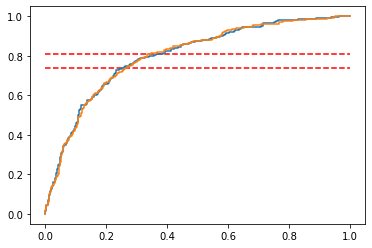

In [41]:
from sklearn.metrics import roc_curve

t_prob = gs.predict_proba(X_test)[:,1]
fpr_gs, tpr_gs, thres = roc_curve(y_test, t_prob)

t_prob = logistic.predict_proba(X_test)[:,1]
fpr_lg, tpr_lg, thres = roc_curve(y_test, t_prob)

plt.plot(fpr_gs, tpr_gs)
plt.plot(fpr_lg, tpr_lg)
plt.hlines([0.807, 0.736], 0, 1, colors=["r", "r"], linestyles = 'dashed')
# plt.ylim(0.6, 0.9)

## SMOTE

Using weight in `LogisticRegression` is equivalent to upsample the minority class. `SMOTE` allows upsampling without repeatedly using same observations: 

In [42]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [43]:
pipe = Pipeline([ 
    ("standardize", StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])

params = {
    "logit__C": [0.0001, 0.01, 1, 100, 10000]
}

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(pipe, params, scoring="roc_auc", cv=skfold)
gs.fit(X_resampled, y_resampled)

print("Cross-Validation score", gs.best_score_)
print("Train Score", gs.score(X_train, y_train)) # Why is this so different from the cv score?
print("Test Score", gs.score(X_test, y_test))

print(roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
confusion_matrix(y_test, gs.predict(X_test))

Cross-Validation score 0.9623680549314311
Train Score 0.8359468226356745
Test Score 0.7764670983241533
0.7764670983241533


array([[1218,   70],
       [ 158,   54]])